In [113]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np

import os
import glob
import ast
import matplotlib

import numpy as np
from scipy.optimize import curve_fit
import scipy

### Notes:
- for RF05 - check the one with least stdev
- for 

In [114]:
before_hwp_rf10 = 0.3433878080732969

In [115]:
def sine_function(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

In [166]:
def fitter(x,y, p0_amp, label = None ):
    #to skip the first faulty measurement
    # x = x[1:]
    # y = y[1:]
    
    p0 = [p0_amp, 2*np.pi/8000, 0, 0]
    params, covariance = curve_fit(sine_function, x, y, p0=p0)

    # Extract the fitted parameters
    A_fit, B_fit, C_fit, D_fit = params

    print(f"{label} - fitted parameters: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit}")
    # Generate y values using the fitted parameters
    steps = np.arange(min(x), max(x), 100)
    y_fit = sine_function(steps, A_fit, B_fit, C_fit, D_fit)

    return params, steps, y_fit

In [117]:
# measurements folder path
folder_path = "measurements\\measurements_after_HWP_fm2\\"
folder_path = "measurements/measurements_after_HWP_fm2/"

# Get all CSV files in the folder
files_after_hwp = glob.glob(os.path.join(folder_path, "*.csv"))
print(len(files_after_hwp), 'after hwp - amount of meas files (inc. darkcounts)')

# before hwp folder path
folder_path = "analog_data/before_hwp/"
files_before_hwp =  glob.glob(os.path.join(folder_path, "*.csv"))
print(len(files_before_hwp), 'before hwp - amount of meas files (inc. darkcounts)')

# read in darkcounts and delete them from the saved files list
darkcounts = pd.read_csv(files_after_hwp.pop(0))
darkcounts_before = pd.read_csv(files_before_hwp.pop(0), skiprows=2)

43 after hwp - amount of meas files (inc. darkcounts)
34 before hwp - amount of meas files (inc. darkcounts)


In [118]:
darkcounts_before_avg = np.average(darkcounts_before[' Measurement'])
print('average darkcount before hwp', darkcounts_before_avg)

average darkcount before hwp 0.007810489861751153


In [119]:
# save all measured rfs into a loaded df -> into a list

all_after = [pd.read_csv(file) for file in files_after_hwp]
all_before = [pd.read_csv(file, skiprows=2) for file in files_before_hwp]

#initiate dicts for saving before avgs
before_hwp_dict = {}
before_hwp_avg = {}
after_hwp_dict = {}



In [120]:
rf10_before = pd.read_csv('measurements\measurements_th100_before_hwp\measured_rf10.csv')
rf10_before = float(rf10_before['averaged'].iloc[0])
print(rf10_before)

0.00210149233885


In [121]:
# after_HWP_Measurements : save into dictionary
for i, data in enumerate(all_after):
    rf = os.path.basename(files_after_hwp[i]).split('rf')[1].split('.csv')[0] #str for rf 
    rf = f'rf{rf}'
    after_hwp_dict[rf] = data
# before_HWP_Measurements : save into Dictionary and another Dictionary for averages
for i, data in enumerate(all_before):

    # get the name
    rf = os.path.basename(files_before_hwp[i]).split('rf_')[1][0:3]
    rf = rf.split('.')[0]
    label = f'rf{rf}'

    before_hwp_dict[label] = data
    before_hwp_avg[label] = np.average(before_hwp_dict[label][' Measurement'])

In [122]:
# a rule for sorting out the loaded measurements according to their names (RFs)
def rfsort(n):
    print(n)
    n = n[2:]
    print(n)
    n = int(n)
    print(n)
    return n
# getting colors for plotting before_HWP data

n_lines = len(before_hwp_avg)
cmap = matplotlib.colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines+7))
print('number of colors, for plots of before_HWP Data', len(colors))

number of colors, for plots of before_HWP Data 40


In [123]:
# sorting keys for before_HWP Average Data - so theyre consistent
keys = sorted(before_hwp_avg.keys(), key=rfsort)

print('amount of keys for before_HWP meas.: ', len(keys), '\nkeys: ', keys)

temp_dict = {}
for key in keys:
    if len(key) == 3:
        newkey = 'rf0' + key.split('rf')[1]
        temp_dict[newkey] = before_hwp_avg[key]
    else:
        temp_dict[key] = before_hwp_avg[key]

before_hwp_avg = temp_dict
print('\nkeys after adjusting name length: ', before_hwp_avg.keys())

rf01
01
1
rf100
100
100
rf15
15
15
rf2
2
2
rf20
20
20
rf25
25
25
rf3
3
3
rf30
30
30
rf35
35
35
rf4
4
4
rf40
40
40
rf45
45
45
rf5
5
5
rf50
50
50
rf55
55
55
rf6
6
6
rf60
60
60
rf65
65
65
rf7
7
7
rf70
70
70
rf75
75
75
rf78
78
78
rf8
8
8
rf80
80
80
rf83
83
83
rf85
85
85
rf88
88
88
rf9
9
9
rf90
90
90
rf92
92
92
rf94
94
94
rf96
96
96
rf98
98
98
amount of keys for before_HWP meas.:  33 
keys:  ['rf01', 'rf2', 'rf3', 'rf4', 'rf5', 'rf6', 'rf7', 'rf8', 'rf9', 'rf15', 'rf20', 'rf25', 'rf30', 'rf35', 'rf40', 'rf45', 'rf50', 'rf55', 'rf60', 'rf65', 'rf70', 'rf75', 'rf78', 'rf80', 'rf83', 'rf85', 'rf88', 'rf90', 'rf92', 'rf94', 'rf96', 'rf98', 'rf100']

keys after adjusting name length:  dict_keys(['rf01', 'rf02', 'rf03', 'rf04', 'rf05', 'rf06', 'rf07', 'rf08', 'rf09', 'rf15', 'rf20', 'rf25', 'rf30', 'rf35', 'rf40', 'rf45', 'rf50', 'rf55', 'rf60', 'rf65', 'rf70', 'rf75', 'rf78', 'rf80', 'rf83', 'rf85', 'rf88', 'rf90', 'rf92', 'rf94', 'rf96', 'rf98', 'rf100'])


In [124]:
# sorting keys for before_HWP Data - so theyre consistent
keys = sorted(before_hwp_dict.keys(), key=rfsort)

print('amount of keys for before_HWP meas.: ', len(keys), '\nkeys: ', keys)

temp_dict = {}
for key in keys:
    if len(key) == 3:
        newkey = 'rf0' + key.split('rf')[1]
        temp_dict[newkey] = before_hwp_dict[key]
    else:
        temp_dict[key] = before_hwp_dict[key]

before_hwp_dict = temp_dict
print('\nkeys after adjusting name length: ', before_hwp_dict.keys())

rf01
01
1
rf100
100
100
rf15
15
15
rf2
2
2
rf20
20
20
rf25
25
25
rf3
3
3
rf30
30
30
rf35
35
35
rf4
4
4
rf40
40
40
rf45
45
45
rf5
5
5
rf50
50
50
rf55
55
55
rf6
6
6
rf60
60
60
rf65
65
65
rf7
7
7
rf70
70
70
rf75
75
75
rf78
78
78
rf8
8
8
rf80
80
80
rf83
83
83
rf85
85
85
rf88
88
88
rf9
9
9
rf90
90
90
rf92
92
92
rf94
94
94
rf96
96
96
rf98
98
98
amount of keys for before_HWP meas.:  33 
keys:  ['rf01', 'rf2', 'rf3', 'rf4', 'rf5', 'rf6', 'rf7', 'rf8', 'rf9', 'rf15', 'rf20', 'rf25', 'rf30', 'rf35', 'rf40', 'rf45', 'rf50', 'rf55', 'rf60', 'rf65', 'rf70', 'rf75', 'rf78', 'rf80', 'rf83', 'rf85', 'rf88', 'rf90', 'rf92', 'rf94', 'rf96', 'rf98', 'rf100']

keys after adjusting name length:  dict_keys(['rf01', 'rf02', 'rf03', 'rf04', 'rf05', 'rf06', 'rf07', 'rf08', 'rf09', 'rf15', 'rf20', 'rf25', 'rf30', 'rf35', 'rf40', 'rf45', 'rf50', 'rf55', 'rf60', 'rf65', 'rf70', 'rf75', 'rf78', 'rf80', 'rf83', 'rf85', 'rf88', 'rf90', 'rf92', 'rf94', 'rf96', 'rf98', 'rf100'])


### Variables at this point:
- dictionaries with label : 'rf###' ; value: data
- before_hwp_dict AND after_hwp_dict
- before_hwp_avg -- Dictionary with label : 'rf###' ; value : average

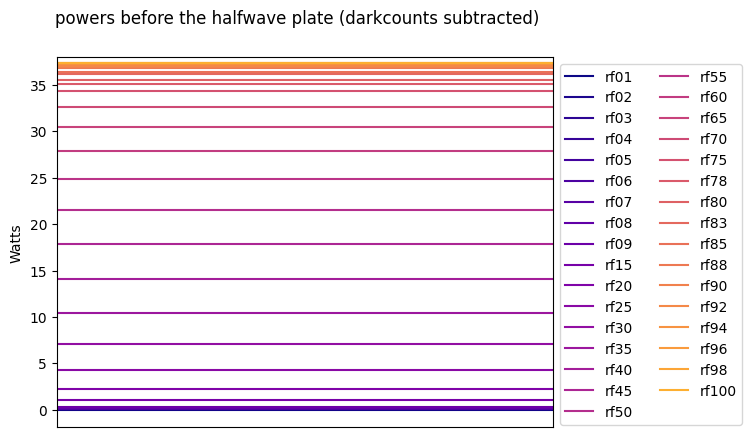

In [125]:
for i, (rf, avg) in enumerate(before_hwp_avg.items()):

    plt.axhline(avg - darkcounts_before_avg, label=rf, color = colors[i])
    plt.legend(ncol= 2, bbox_to_anchor = (1,1))
    plt.ylabel('Watts')
    plt.suptitle('powers before the halfwave plate (darkcounts subtracted)')
    
    #x ticks off
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off   

In [126]:
print(darkcounts_before)

     Sample #   Measurement
0           1      0.016400
1           2      0.015100
2           3      0.006698
3           4      0.002299
4           5     -0.003199
..        ...           ...
429       430      0.010200
430       431      0.009898
431       432      0.008898
432       433      0.007398
433       434      0.005199

[434 rows x 2 columns]


In [127]:
def cdf(x, A, B, C):
    res  =  C * scipy.stats.norm(A,B).cdf(x)
    return res

In [128]:
x_fit = np.linspace(0, 100, 100)

fitted params 46.73495849169865 18.80166308869992 37.21189907315227


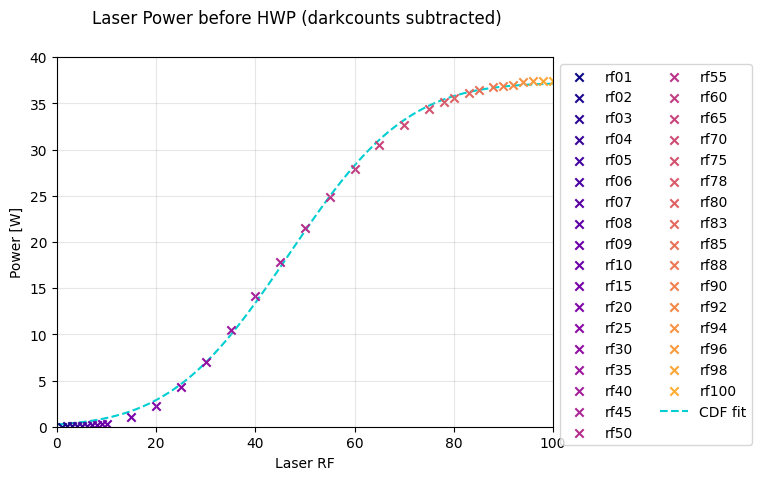

In [129]:
x = []
y = []

for i, (rf, avg) in enumerate(before_hwp_avg.items()):
    plt.scatter(int(rf[2:]), avg - darkcounts_before_avg, color = colors[i], label = rf, marker='x')
    x.append(float(rf[2:]))
    y.append(avg)
    if i == 8:
        plt.scatter(10, before_hwp_rf10, color = colors[i], marker='x', label = 'rf10')


x.append(10)
y.append(0.35)

plt.xlabel('Laser RF')
plt.ylabel('Power [W]')
plt.suptitle("Laser Power before HWP (darkcounts subtracted)")
# mu, sigma, amp = curve_fit(f = cdf, xdata = x, ydata = avg - darkcounts_before_avg, p0=[50, 20, 40])[0]
mu, sigma, amp = curve_fit(f = cdf, xdata = x, ydata = y, p0=[50, 18, 35])[0]
plt.plot(x_fit, cdf(x_fit, mu, sigma, amp), color ='darkturquoise', zorder = -2, linestyle = 'dashed', label = 'CDF fit')
plt.legend(ncol = 2, bbox_to_anchor = (1,1))

print('fitted params', mu, sigma, amp)

plt.xlim(0,100)
plt.ylim(0, 40)
plt.grid(which='both', alpha = 0.3)
plt.savefig('results/powersbeforehwp.png', bbox_inches="tight")

In [130]:
colors2 = cmap(np.linspace(0, 1, 42))

In [131]:
# re-saving steps counts
keys_after = list(after_hwp_dict.keys()) 
for i, key in enumerate(keys_after):
    after_hwp_dict[key]['rotor_step'] = after_hwp_dict[key].apply(lambda x: x['rotor_step'].split('[')[1].split(',')[0], axis = 1) #OK!
    after_hwp_dict[key]['rotor_step'] = after_hwp_dict[key]['rotor_step'].apply(lambda x: int(x))

In [132]:
print('keys for accessing the dictionary data for each entry: \n', after_hwp_dict['rf01'].keys())


keys for accessing the dictionary data for each entry: 
 Index(['rotor_step', 'raw_data', 'averaged', 'stdev'], dtype='object')


In [133]:

for i, key in enumerate(keys_after):
    print(f'index: {i}, label: {key}')

index: 0, label: rf01
index: 1, label: rf012
index: 2, label: rf01_02
index: 3, label: rf02
index: 4, label: rf02_02
index: 5, label: rf03
index: 6, label: rf03_02
index: 7, label: rf04
index: 8, label: rf04_02
index: 9, label: rf04_03
index: 10, label: rf05_06_N48_blackmeasurement_nosleep
index: 11, label: rf06
index: 12, label: rf07
index: 13, label: rf08
index: 14, label: rf09
index: 15, label: rf10
index: 16, label: rf100
index: 17, label: rf10_02
index: 18, label: rf10_right
index: 19, label: rf15
index: 20, label: rf20
index: 21, label: rf25
index: 22, label: rf30
index: 23, label: rf35
index: 24, label: rf40
index: 25, label: rf45
index: 26, label: rf50
index: 27, label: rf55
index: 28, label: rf60
index: 29, label: rf65
index: 30, label: rf70
index: 31, label: rf75
index: 32, label: rf80
index: 33, label: rf85
index: 34, label: rf90
index: 35, label: rf92
index: 36, label: rf94
index: 37, label: rf96
index: 38, label: rf98
index: 39, label: rfdarkcount_20241022
index: 40, label

In [134]:
darkcount_after_avg = np.average(darkcounts['averaged'])
print('darkcount', darkcount_after_avg)
print('the stdev is 10 times smaller', np.average(after_hwp_dict[keys_after[17]]['stdev']))

darkcount -0.03452952076913785
the stdev is 10 times smaller 0.0035141811782805283


In [ ]:
ratio_darkcount_to_max = 0.8031035331516106

rf10_right - fitted parameters: A=0.19533920886600212, B=0.0006976592894635332, C=0.7764768988095978, D=0.22947954414825186
min val of fit 0.03421685273908029
fitted parameters: [1.95339209e-01 6.97659289e-04 7.76476899e-01 2.29479544e-01]
period is 9006.094238365344
before 10 avg calculated 0.3433878080732969


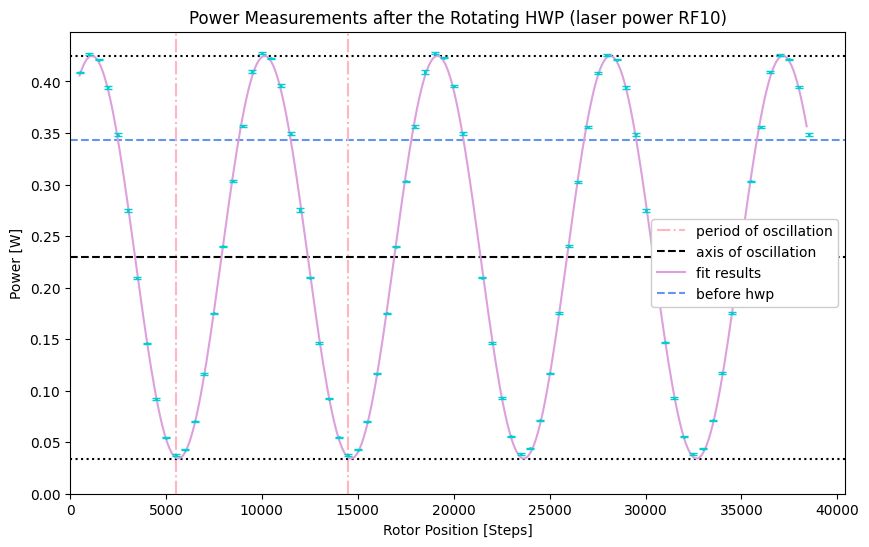

In [136]:
# rf10 plot over long range

fig, ax = plt.subplots(1,1, figsize =  (10,6))
ax.set_title('Power Measurements after the Rotating HWP (laser power RF10)')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Rotor Position [Steps]')


# guides, zeros
# ax.axhline(-darkcount_after_avg, color = 'darkturquoise', label = 'darkcount subtracted')


rf10s = [ 17, 18]

vals = np.array([])
steps = np.array([])
errors  = np.array([])

for index in rf10s:
    key = keys_after[index]
    data = after_hwp_dict[key]

    steps = np.append(steps, np.array(data['rotor_step'][1:]))
    vals = np.append(vals, np.array(data['averaged'][1:]))
    errors = np.append(errors, np.array(data['stdev'][1:]))

vals = vals.flatten() - darkcount_after_avg
vals -= np.average(darkcounts['averaged'])
steps = steps.flatten()


params, fitsteps, y_fit, x_fit = fitter(steps, vals, p0_amp = max(vals), label=key)
print('min val of fit' , min(y_fit))
xmin =  x_fit[np.where(y_fit < min(y_fit)+ 0.001)[0][0] ]
ax.axvline(xmin, linestyle = 'dashdot', color ='lightpink')
ax.axvline(xmin +2*np.pi/ params[1], linestyle = 'dashdot', color ='lightpink' , label ='period of oscillation')
ax.axhline(params[3], label = 'axis of oscillation', linestyle = 'dashed', color = 'black')
ax.axhline(params[3] - params[0], linestyle = 'dotted', color = 'black')
ax.axhline(params[3] + params[0], linestyle = 'dotted', color = 'black')

print(f'fitted parameters: {params}')
print('period is', 2*np.pi/ params[1])
plt.plot(fitsteps, y_fit, color = 'plum', label = 'fit results', alpha = 1)
plt.errorbar(x=steps, y=vals, yerr = errors, fmt = 'o' ,markersize=1, capsize=3 , color ='darkturquoise')

maxval = max(vals)
beforehwp_rf10_avg = maxval * ratio_darkcount_to_max
print('before 10 avg calculated', beforehwp_rf10_avg)
ax.axhline(beforehwp_rf10_avg, color ='cornflowerblue', label = 'before hwp', linestyle = 'dashed', zorder = -2)

plt.xlim(left = 0)
plt.ylim(bottom = 0)
plt.legend(framealpha = 1)
plt.savefig('results/rf10longrange.png')

# After HWP - fits

the girls with the wings on the far right:
0 rf01
the girls with the wings on the far right:
1 rf012
the girls with the wings on the far right:
3 rf02


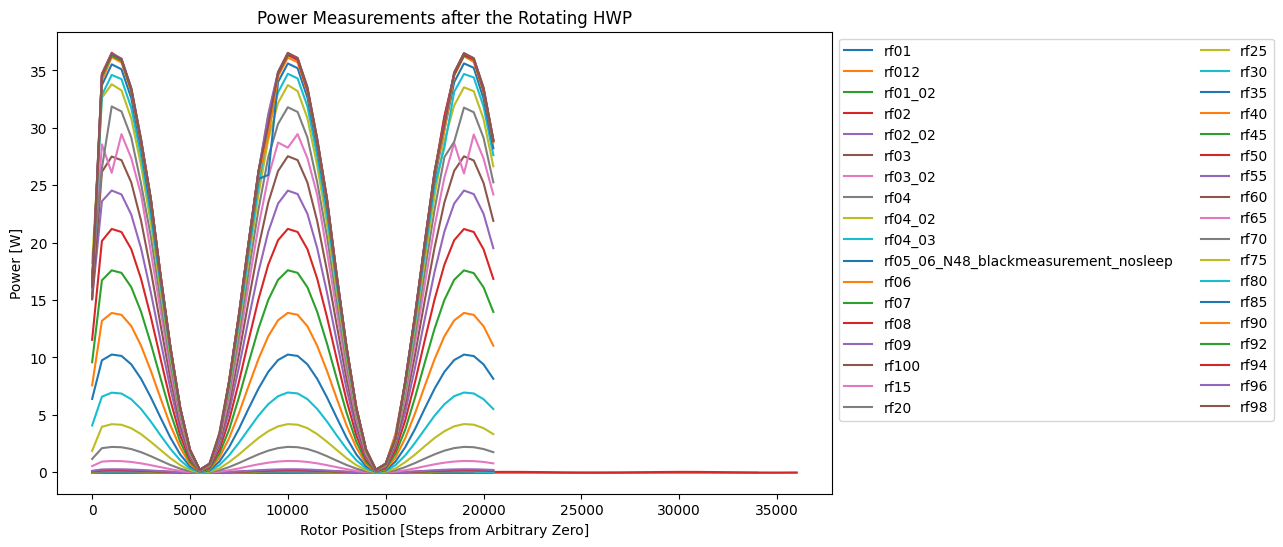

In [160]:
fig, ax = plt.subplots(1,1, figsize =  (10,6))
ax.set_title('Power Measurements after the Rotating HWP')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Rotor Position [Steps from Arbitrary Zero]')

# ax.axhline(np.average(darkcounts['averaged']), color = 'green', label = 'darkcount')

for i, key in enumerate(after_hwp_dict.keys()):
    # print(key, len(keys_after))
    rule = ( i < 40)  
    if rule :
        data = after_hwp_dict[key]
        steps = np.array(data['rotor_step'])
        if np.any(steps>30000):
            print('the girls with the wings on the far right:')
            print(i, key)
        vals = data['averaged']
        # error = np.array(data['stdev'])
        plt.plot(steps, vals, label = key)


plt.legend(ncol =2 ,bbox_to_anchor = (1,1) )
# plt.xlim(25000, 35000)

In [180]:
# deleting useless randos

# del after_hwp_dict['rf10']
# del after_hwp_dict['rf10_right']
# del after_hwp_dict['rf10_02']
# del after_hwp_dict['rfdarkcount_20241022']
# del after_hwp_dict['rftest_poweroff']
# del after_hwp_dict['rftest_cooling2']
# del after_hwp_dict['rf04']
# del after_hwp_dict['rf04_02']
# after_hwp_dict['rf04'] = after_hwp_dict['rf04_03']
# del after_hwp_dict['rf04_03']


In [162]:
# results of the fits - A:amp, B:wavenum, C:phase_shift, D:offset
fit_params_results = np.zeros((len(after_hwp_dict), 4), dtype=float)

!!YO!! index 0, key: rf01
rf01 - fitted parameters: A=7.518339442120142e-05, B=0.0005933594090776436, C=3.406661751035975, D=-0.03401615918379423


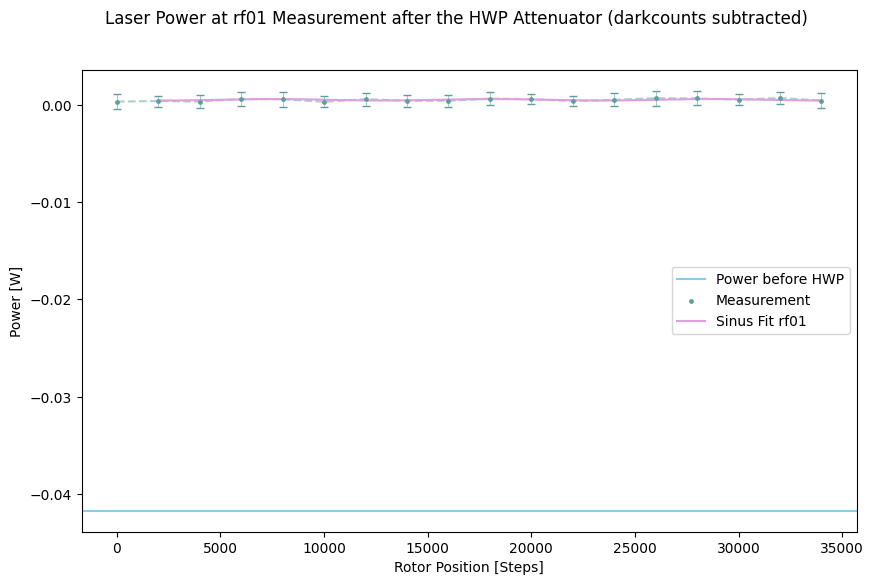

!!YO!! index 1, key: rf012
rf012 - fitted parameters: A=7.083255091244707e-05, B=0.000906392436603307, C=-2.6620456386010667, D=-0.03402110915912535
rf012 isnt measured at before hwp


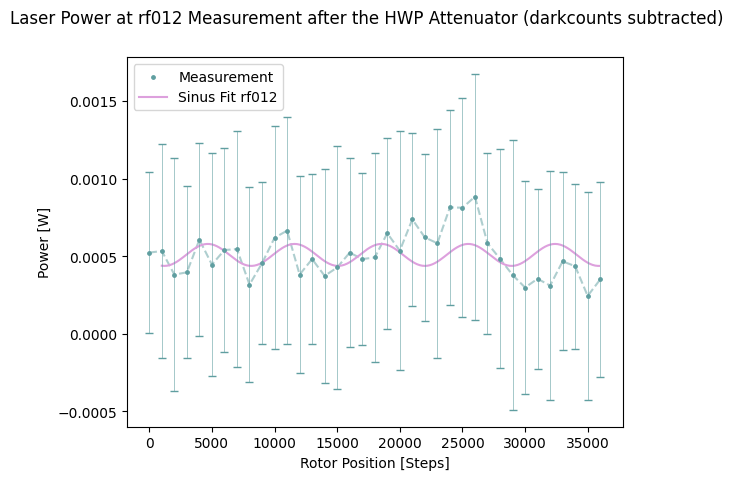

!!YO!! index 2, key: rf01_02
rf01_02 - fitted parameters: A=0.0003564522127554012, B=0.0006825429980004016, C=0.48632567186060066, D=-0.032064858102999236
rf01_02 isnt measured at before hwp


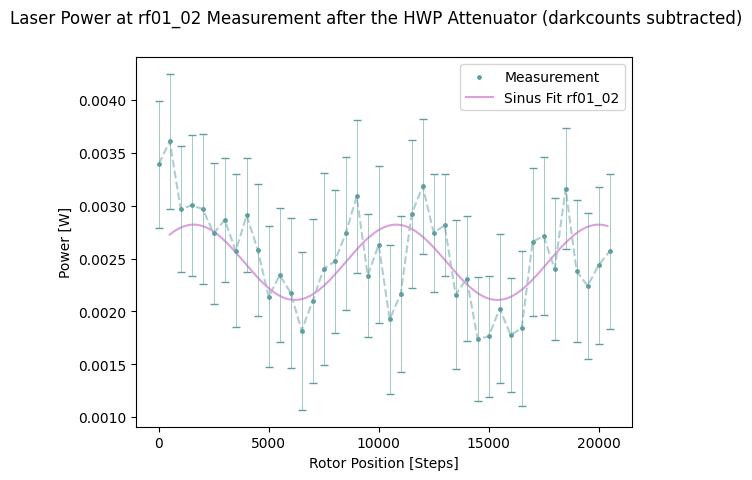

!!YO!! index 3, key: rf02
rf02 - fitted parameters: A=-0.03618801081934481, B=0.0006992629906252075, C=2.4053444659152157, D=0.0038115646380822163


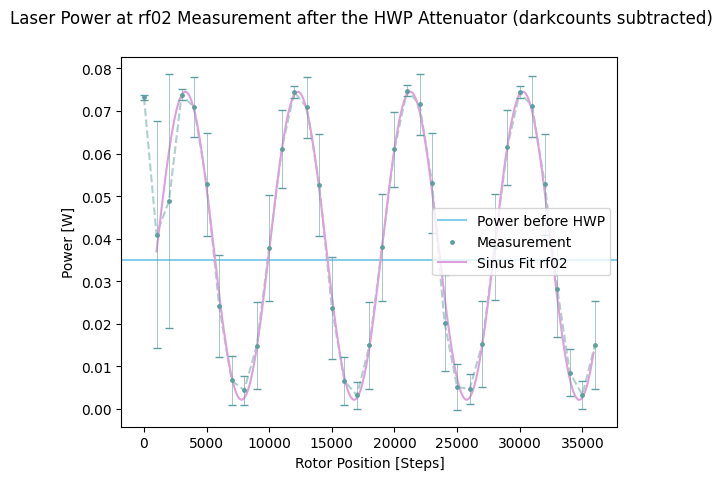

!!YO!! index 4, key: rf02_02
rf02_02 - fitted parameters: A=0.037831317261265124, B=0.0006991433913095518, C=0.7701875962928475, D=0.00700765678296687
rf02_02 isnt measured at before hwp


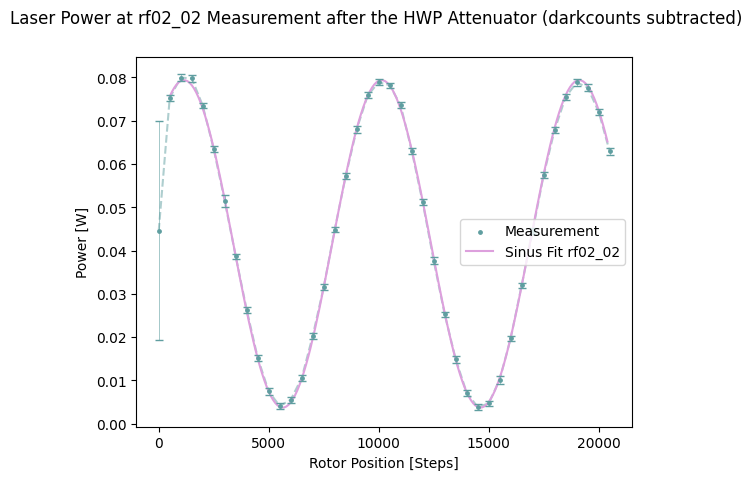

!!YO!! index 5, key: rf03
rf03 - fitted parameters: A=0.03827529750387149, B=0.0006973791968481134, C=0.7699232165589991, D=0.00828156993705134


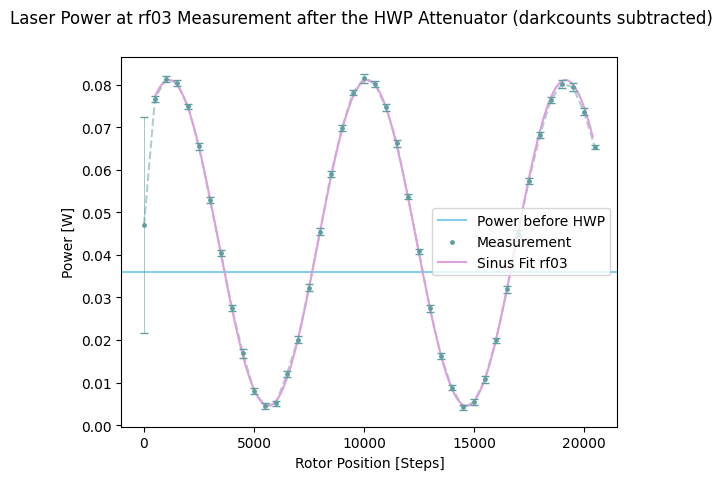

!!YO!! index 6, key: rf03_02
rf03_02 - fitted parameters: A=0.03804390988984928, B=0.000698359288448811, C=0.7757070904236262, D=0.005326567605560708
rf03_02 isnt measured at before hwp


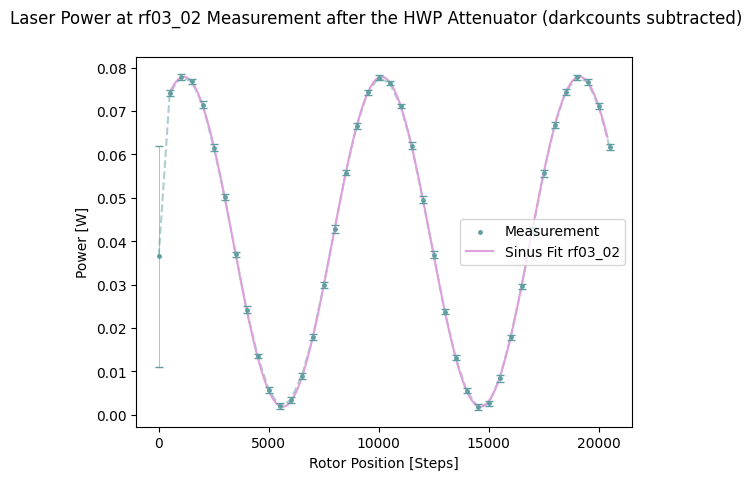

!!YO!! index 7, key: rf05_06_N48_blackmeasurement_nosleep
rf05_06_N48_blackmeasurement_nosleep - fitted parameters: A=0.05371892723684034, B=0.0006979637977887489, C=0.7813273885837181, D=0.020235676944434178
rf05_06_N48_blackmeasurement_nosleep isnt measured at before hwp


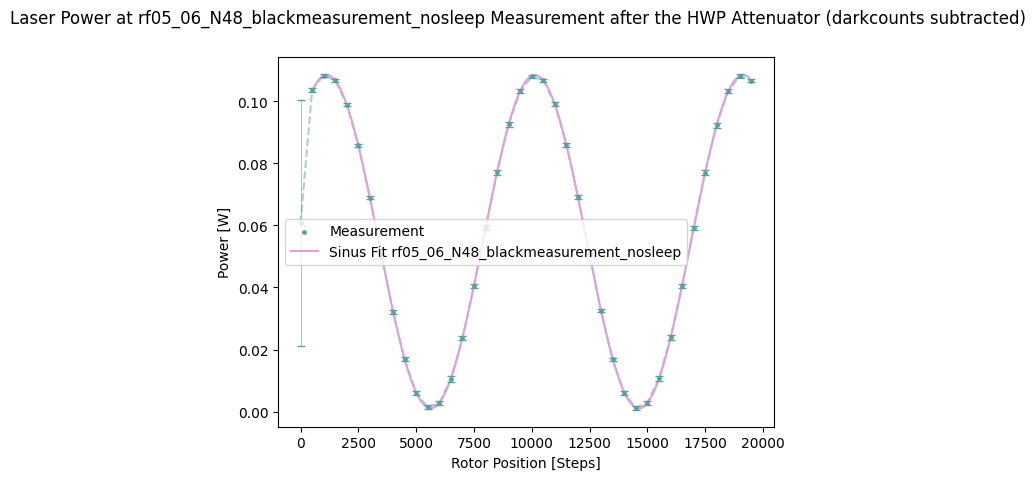

!!YO!! index 8, key: rf06
rf06 - fitted parameters: A=0.0706054316790939, B=0.0006981102036337647, C=0.778305840728361, D=0.03750592542126659


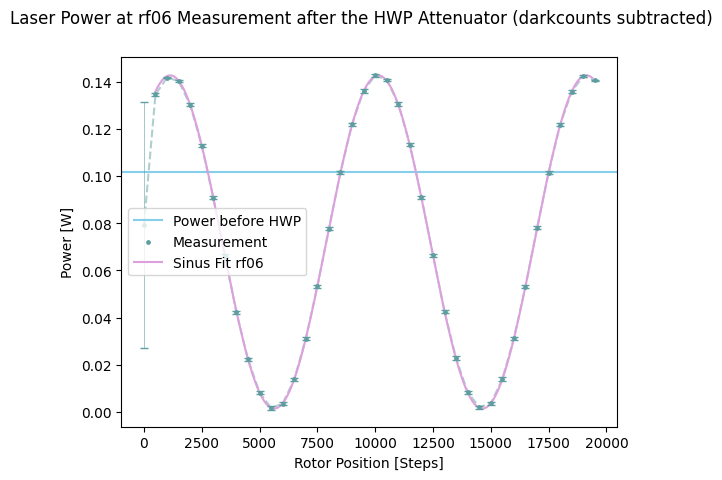

!!YO!! index 9, key: rf07
rf07 - fitted parameters: A=0.09212469282528613, B=0.0006980425308408753, C=0.7802838750634548, D=0.05910561446431206


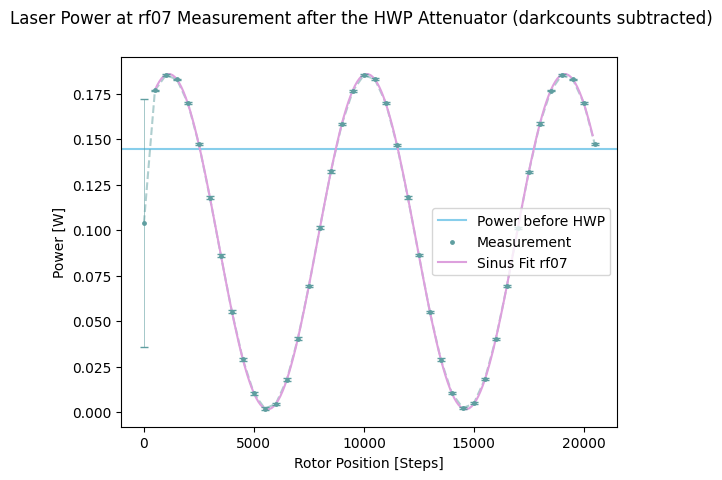

!!YO!! index 10, key: rf08
rf08 - fitted parameters: A=0.11810536873258366, B=0.0006981977003288577, C=0.7752550185311904, D=0.08540474074558409


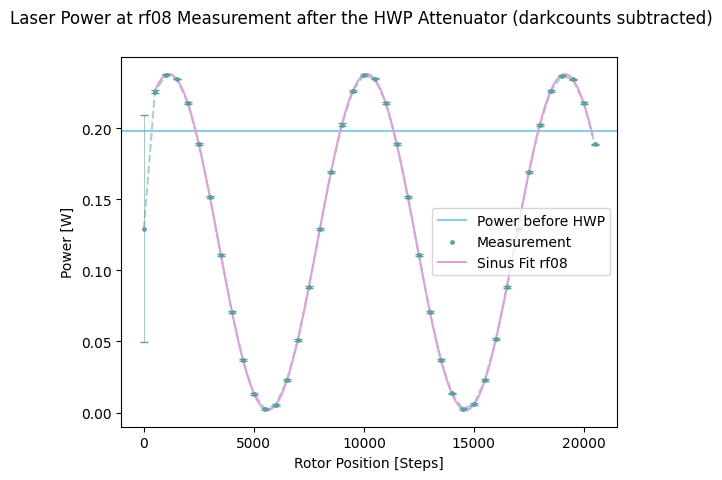

!!YO!! index 11, key: rf09
rf09 - fitted parameters: A=0.1498575844439466, B=0.0006980078373937582, C=0.7797386701107906, D=0.11733308877199693


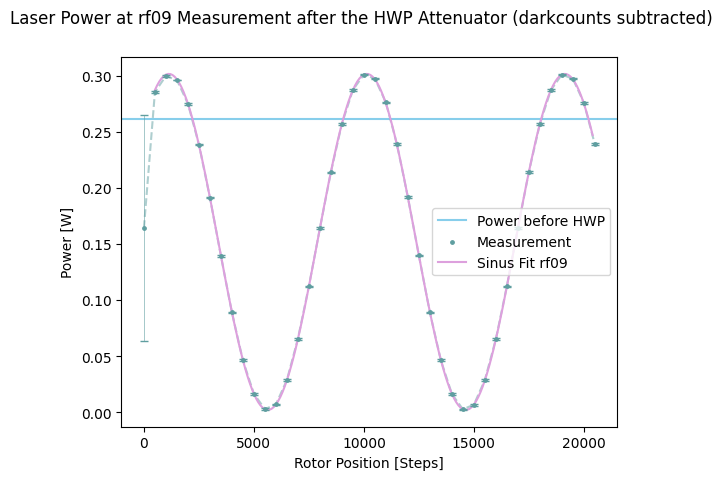

!!YO!! index 12, key: rf100
rf100 - fitted parameters: A=18.17220987642345, B=0.0006983572987462047, C=0.7707095515949626, D=18.402447739258406


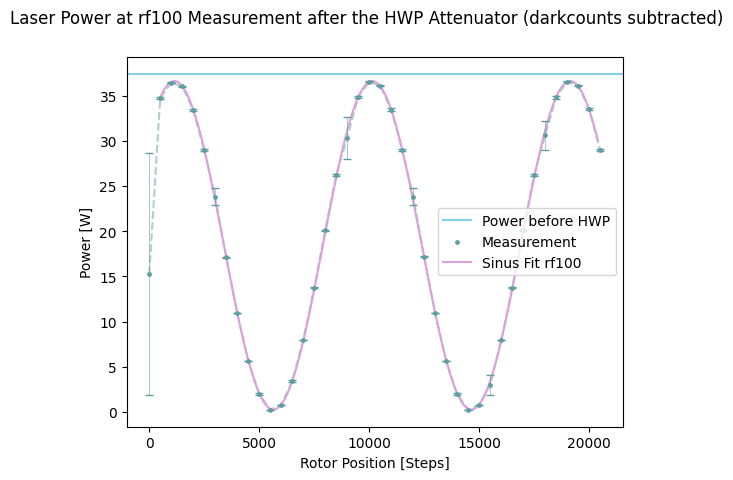

!!YO!! index 13, key: rf15
rf15 - fitted parameters: A=0.5107060388968993, B=0.0006985675367481983, C=0.7686131732991268, D=0.482362653867208


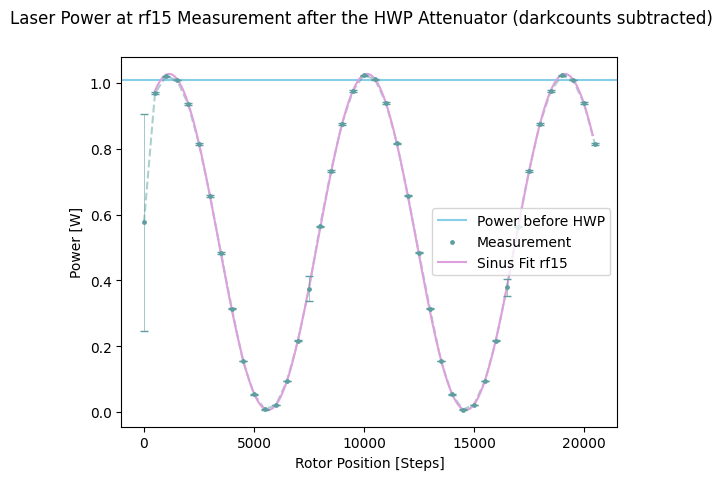

!!YO!! index 14, key: rf20
rf20 - fitted parameters: A=1.1217356344568699, B=0.0006983082994947185, C=0.7744295417864109, D=1.102134569080162


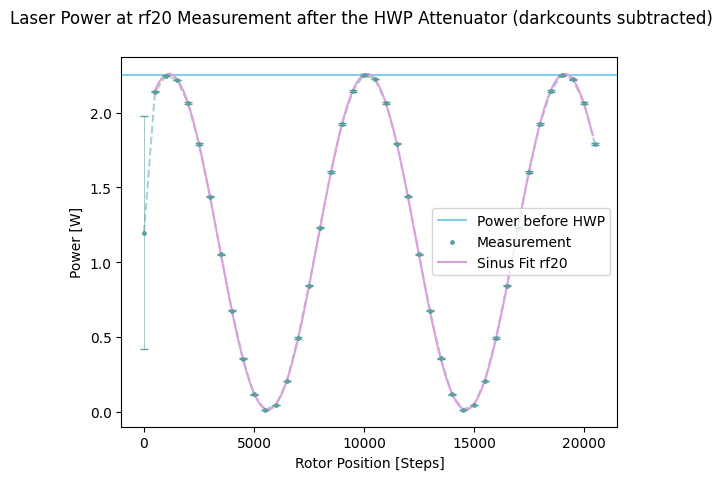

!!YO!! index 15, key: rf25
rf25 - fitted parameters: A=2.1114929854003583, B=0.0006983404969842004, C=0.7751081422779479, D=2.1014316941814886


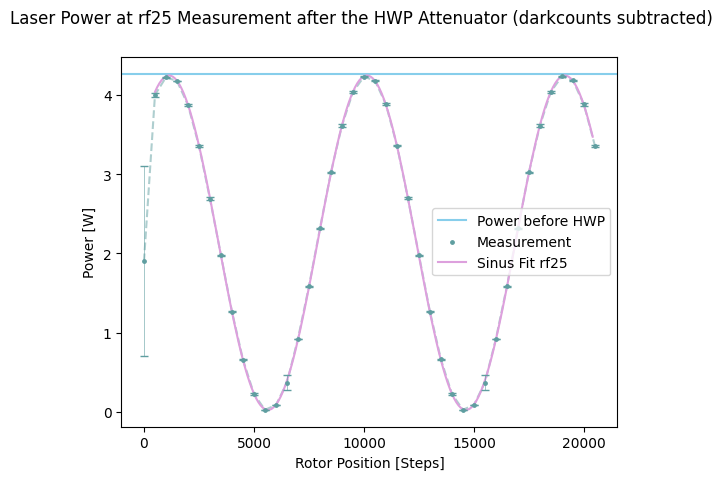

!!YO!! index 16, key: rf30
rf30 - fitted parameters: A=3.4817430684807578, B=0.0006982132164952087, C=0.7759121796670393, D=3.489802669486712


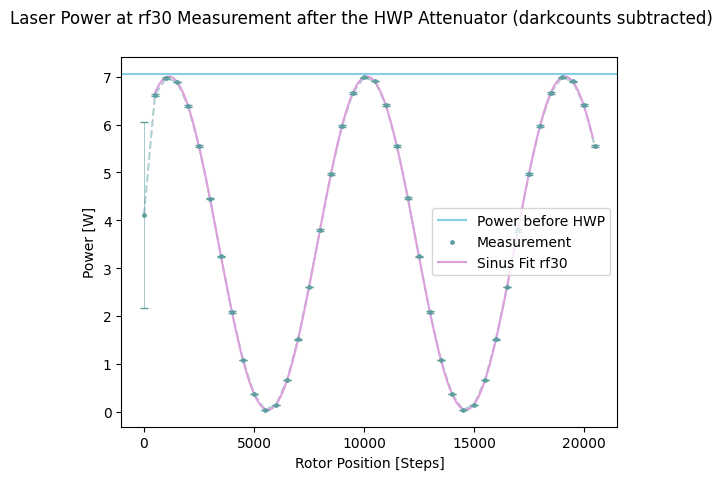

!!YO!! index 17, key: rf35
rf35 - fitted parameters: A=5.134427993265134, B=0.0006981761133635927, C=0.7763238350745744, D=5.156194164351514


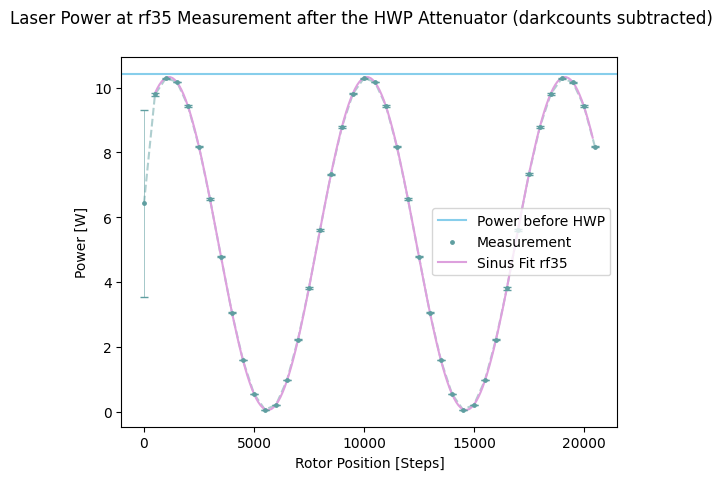

!!YO!! index 18, key: rf40
rf40 - fitted parameters: A=6.939872463296968, B=0.0006981788297290032, C=0.7762447272934923, D=6.986837391176248


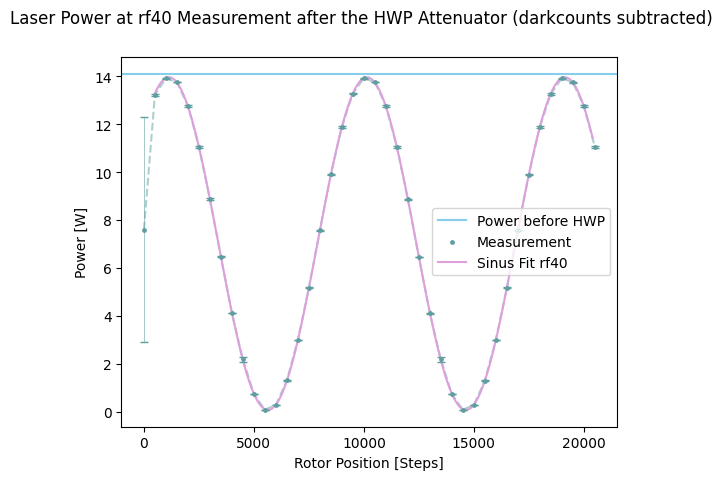

!!YO!! index 19, key: rf45
rf45 - fitted parameters: A=8.798815889909816, B=0.0006982799599342002, C=0.775031480879619, D=8.848437378951115


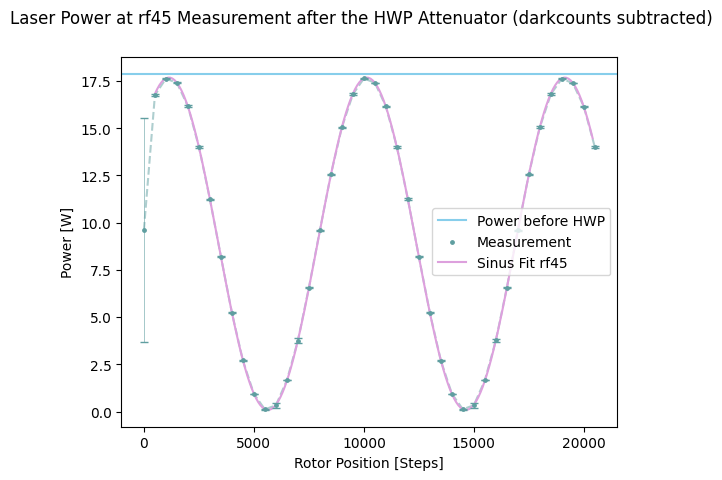

!!YO!! index 20, key: rf50
rf50 - fitted parameters: A=10.593700271246764, B=0.0006981979747690287, C=0.7757345966987531, D=10.674405631545708


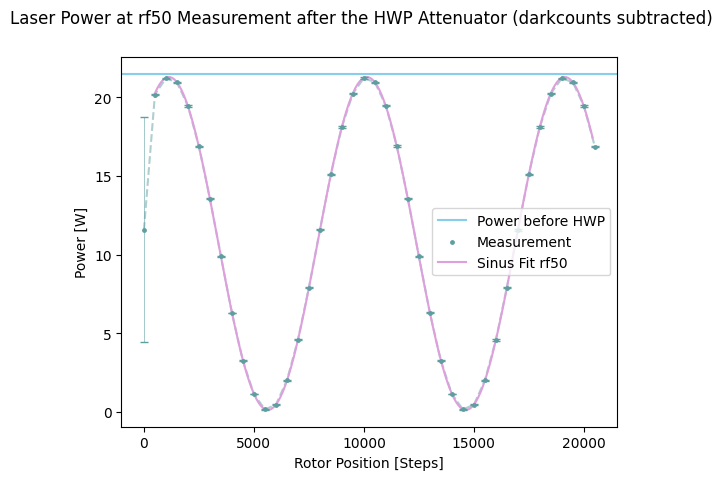

!!YO!! index 21, key: rf55
rf55 - fitted parameters: A=12.26887690054658, B=0.0006979551781997615, C=0.7796822967708814, D=12.375174134239622


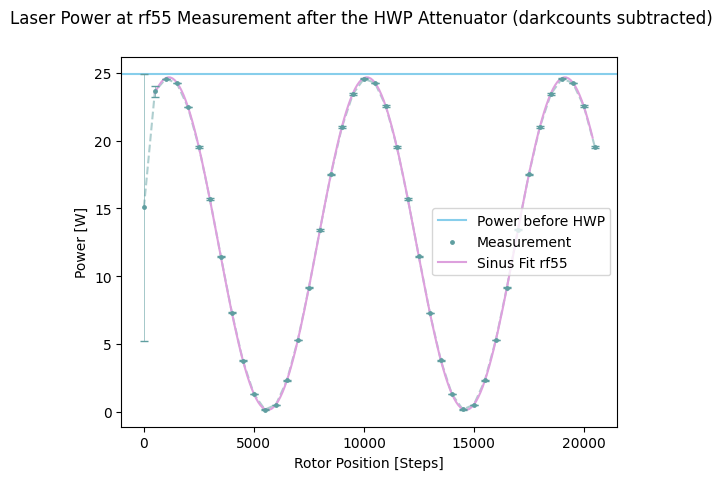

!!YO!! index 22, key: rf60
rf60 - fitted parameters: A=13.746444880756442, B=0.0006983144828505051, C=0.7749087530388019, D=13.870517604343217


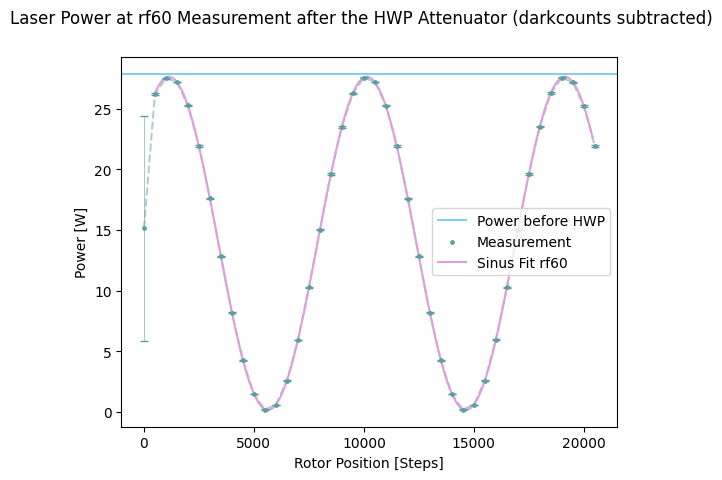

!!YO!! index 23, key: rf65
rf65 - fitted parameters: A=14.573549107772644, B=0.0006989484650860784, C=0.7624896969752625, D=14.944625129902349


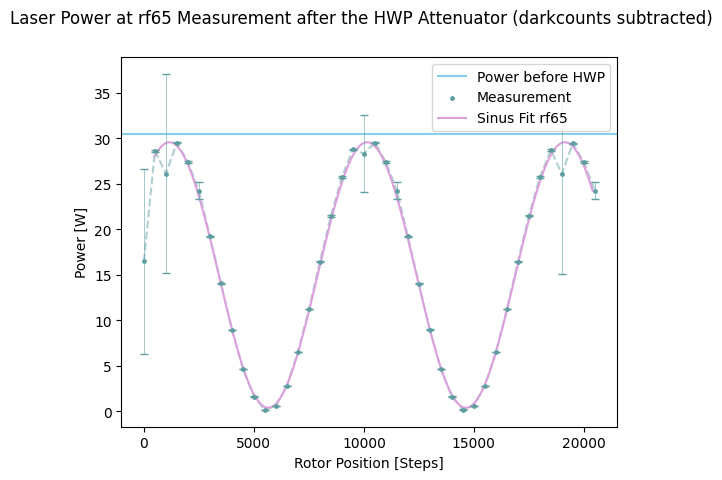

!!YO!! index 24, key: rf70
rf70 - fitted parameters: A=15.691159347075057, B=0.0007002217848439881, C=0.7487789346118027, D=15.965956160757418


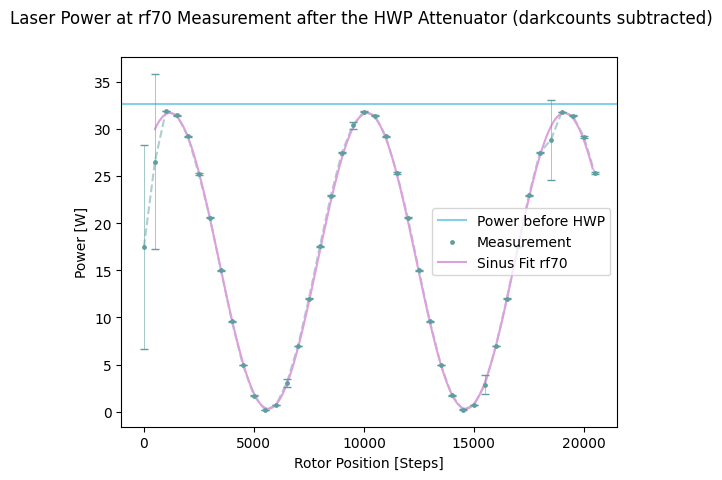

!!YO!! index 25, key: rf75
rf75 - fitted parameters: A=16.856761372966055, B=0.0006982600645638572, C=0.7773272344882654, D=17.001076943033322


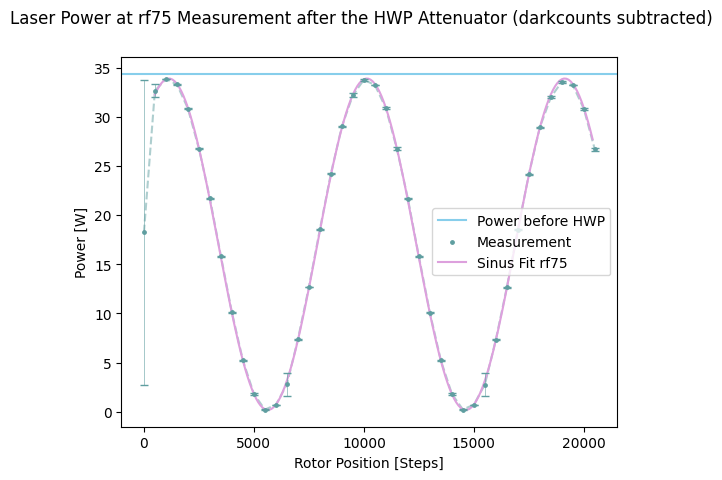

!!YO!! index 26, key: rf80
rf80 - fitted parameters: A=17.305645343374977, B=0.000697866644548474, C=0.7755314183263539, D=17.5173970173349


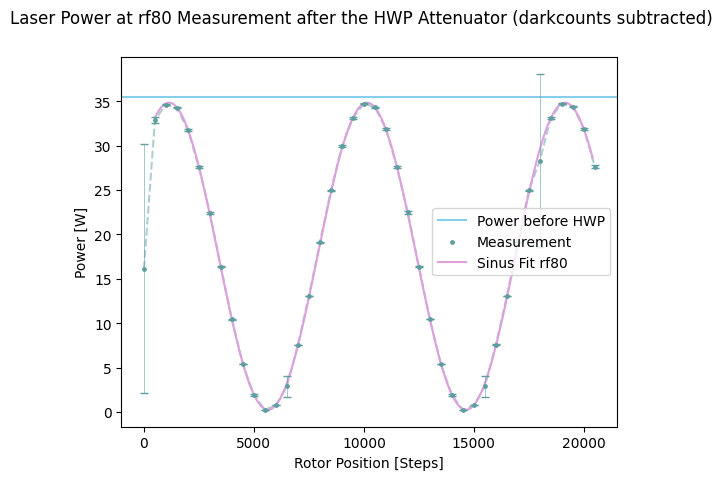

!!YO!! index 27, key: rf85
rf85 - fitted parameters: A=17.633107974281128, B=0.0006992397584107097, C=0.7534846366967248, D=17.85549087559871


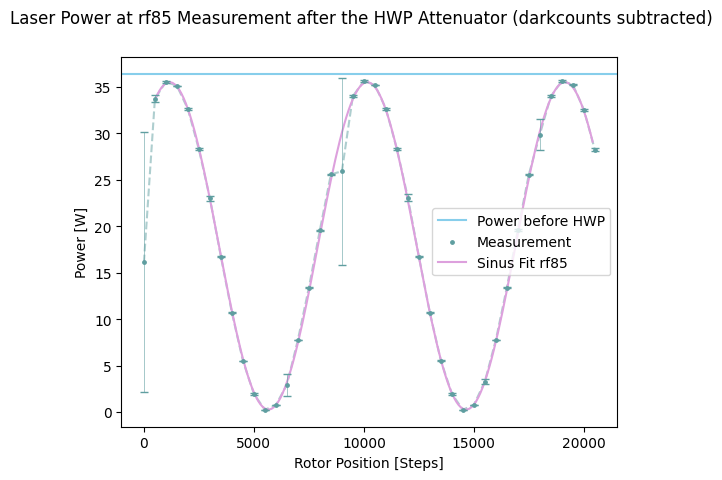

!!YO!! index 28, key: rf90
rf90 - fitted parameters: A=17.967443134710933, B=0.000698636098896899, C=0.7637641717121656, D=18.206957135800497


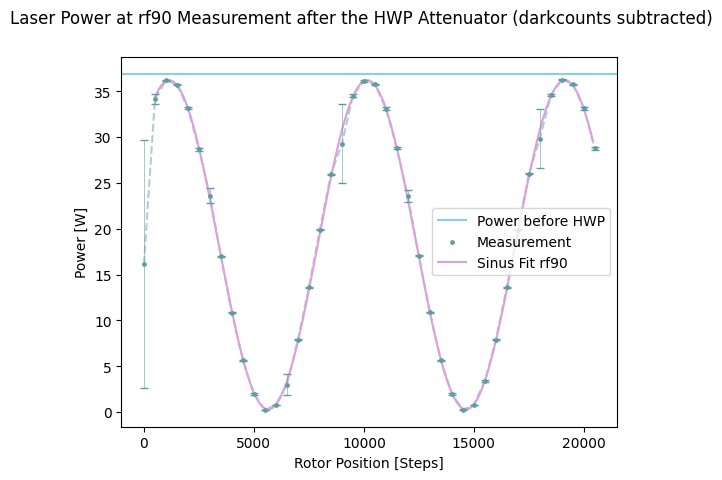

!!YO!! index 29, key: rf92
rf92 - fitted parameters: A=18.15940512565378, B=0.0006987232301884639, C=0.7675119178287264, D=18.35391749412806


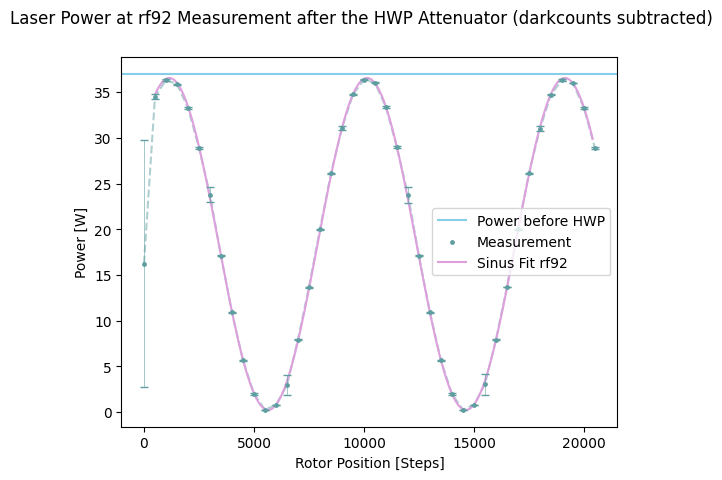

!!YO!! index 30, key: rf94
rf94 - fitted parameters: A=18.189886136953014, B=0.0006987677795494126, C=0.7677848694128581, D=18.36695698915042


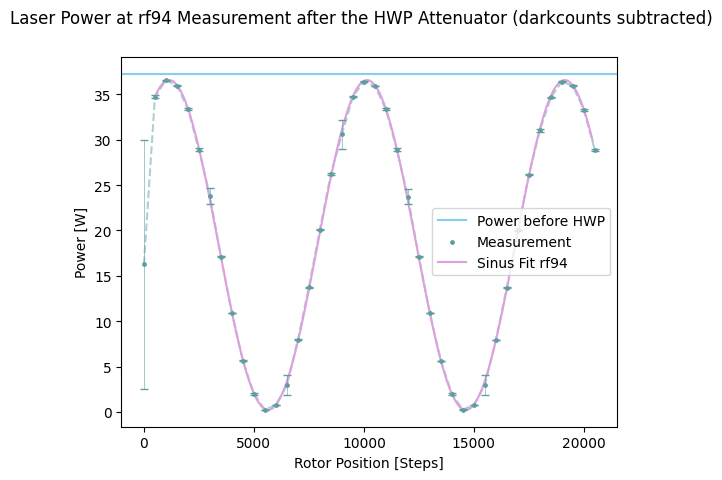

!!YO!! index 31, key: rf96
rf96 - fitted parameters: A=18.230117196084812, B=0.0006984204933080134, C=0.7693602078986685, D=18.428984710839256


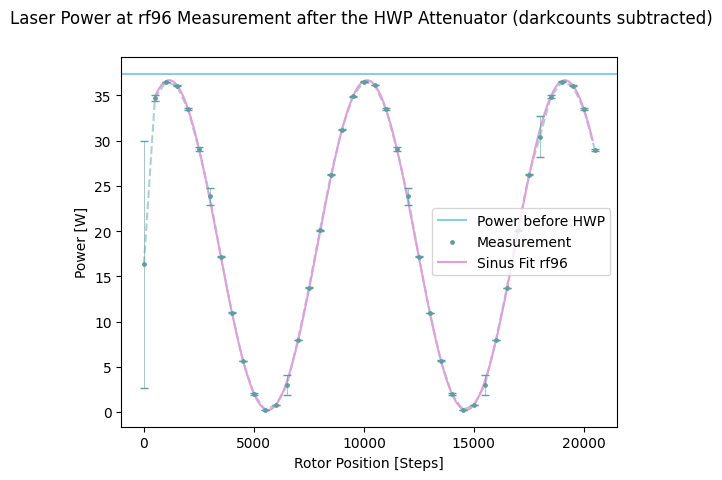

!!YO!! index 32, key: rf98
rf98 - fitted parameters: A=18.1709887797168, B=0.0006982724406999415, C=0.769225885218902, D=18.411403601878284


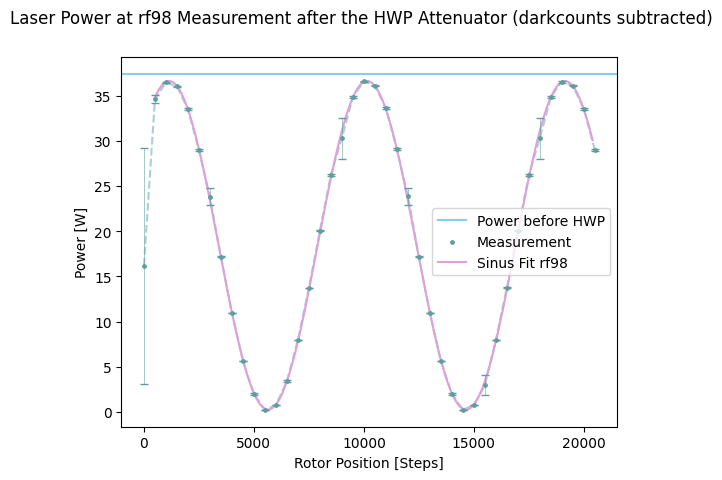

!!YO!! index 33, key: rf04
rf04 - fitted parameters: A=0.03928035184466624, B=0.0006978591612965668, C=0.7906782961771522, D=0.006940288594564959


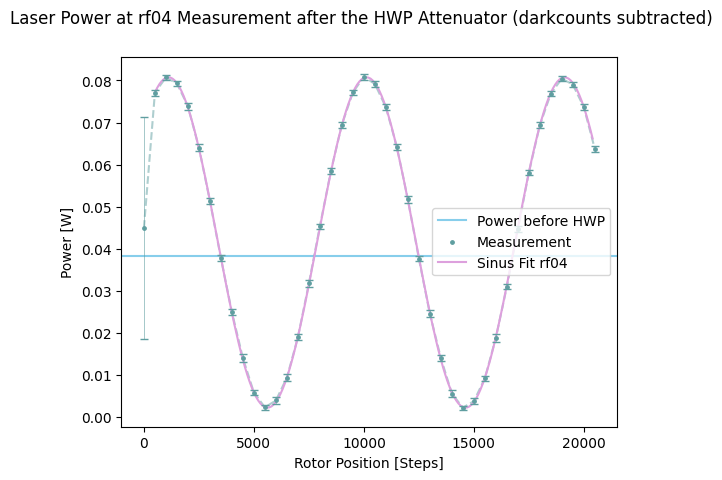

In [212]:
fig, ax = plt.subplots(1,1, figsize =  (10,6))


for i, key in enumerate(after_hwp_dict.keys()):
    print(f'!!YO!! index {i}, key: {key}')
    data = after_hwp_dict[key]
    steps = np.array(data['rotor_step'])
    vals = data['averaged']
    error = np.array(data['stdev'])

    params, fitsteps, y_fit = fitter(steps[1:], vals[1:], p0_amp = max(vals), label=key) #miss that first step it's messed up
    fit_params_results[i] = params

    # plot level before HWP
    try: # dkc suubtracted
        plt.axhline(before_hwp_avg[key] - darkcounts_before_avg, label = f'Power before HWP', color = 'skyblue')
    except KeyError:
        print(f'{key} isnt measured at before hwp')

    # dkc subtracted
    plt.scatter(steps , vals - darkcount_after_avg, label = 'Measurement', color = 'cadetblue', marker = 'o', s= 6,  zorder = 3)
    plt.plot(steps , vals - darkcount_after_avg, color = 'cadetblue', linestyle = 'dashed', alpha = 0.5)
    plt.plot(fitsteps, y_fit - darkcount_after_avg, color = 'plum', label = f'Sinus Fit {key}', alpha = 1, zorder = 2)
    plt.errorbar(x = steps, y = vals - darkcount_after_avg, yerr= error, fmt = 'none', elinewidth=.4, markersize = 1, capsize =3 , color = 'cadetblue', zorder =3)



    #formatting
    plt.suptitle(f'Laser Power at {key} Measurement after the HWP Attenuator (darkcounts subtracted)')
    plt.ylabel('Power [W]')
    plt.xlabel('Rotor Position [Steps]')
    plt.legend()
    plt.show()

0 rf01
hello ! | 


ValueError: 'x' and 'y' must have the same size

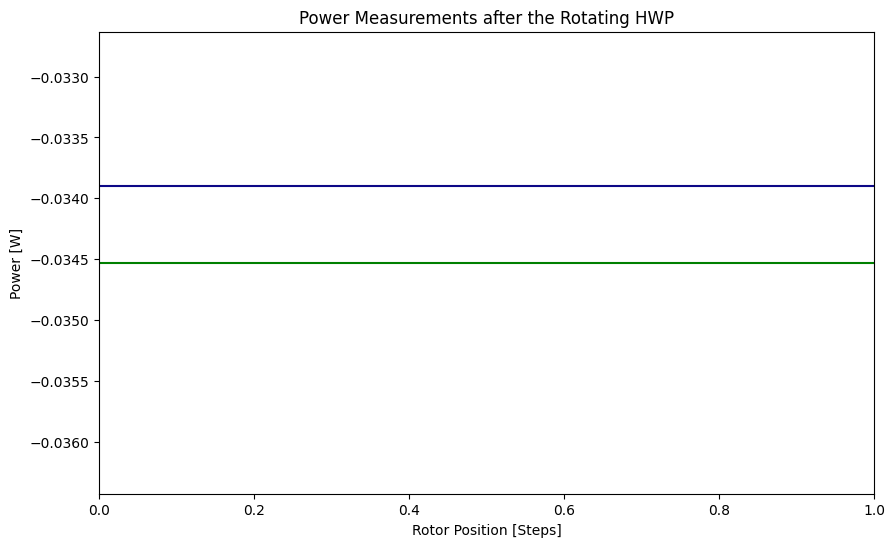

In [169]:
# plot all rfs tgt

fig, ax = plt.subplots(1,1, figsize =  (10,6))
ax.set_title('Power Measurements after the Rotating HWP')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Rotor Position [Steps]')

#darkcount line
ax.axhline(np.average(darkcounts['averaged']), color = 'green', label = 'darkcount')
#before hwp average

for i, data in enumerate(all_after):
   
    rf = os.path.basename(files_after_hwp[i+1]).split('rf')[1]
    # rf = os.path.basename(files_after_hwp[i+1]).split('rf')[1]
    if (not '100' in rf):
        rf = rf[0:2]
        label = f'rf{rf}'
    else:
        rf = rf[0:3]
        label = f'rf{rf}'

    # if 'N48' in os.path.basename(files_after_hwp[i+1]) or '03' in os.path.basename(files_after_hwp[i+1]):
    # if (rf == '15') or (rf=='10'):
    if i>=0 :
        print(i, label)
        print('hello ! | ')
        y = data['averaged']
        error = np.array(data['stdev'])

        # params, params_covariance = curve_fit(sine_function, x[3:], y[3:], p0 = [0.0361029908,0.0998, 3.87, 0.0046])
        # plt.plot(x, sine_function(x, *params), label='Fitted Sine Function', color='red')
        # print(i, "Fitted Parameters: A = {}, B = {}, C = {}, D = {}".format(*params))
        try:
            ax.axhline(before_hwp_avg[label], color = colors2[i], label = f'{label} before hwp')
        except KeyError:
            print(f'{label} isnt measured at before hwp')
        # ax.scatter(x, y, label=label, marker='x')
        # ax.plot(x, y, label=label, color = colors[i])
        ax.errorbar(x = x, y = y, yerr=error, fmt='-o', color = colors2[i], markersize = 0)
        # ax.errorbar(x = x, y = y, yerr=error, fmt='x', color = 'black', markersize = 1)
    ax.axvline(10000+100, color = 'black')
    
ax.legend(ncol = 2 ,bbox_to_anchor = (1,1))

In [ ]:
x = np.zeros(len(data['rotor_step']), dtype=float)

for j,step in enumerate(data['rotor_step']):
    lst = ast.literal_eval(step)
    array = np.array(lst, dtype=float)
    x[j] = array[0]

41 rfte
hello ! | 
rfte isnt measured at before hwp


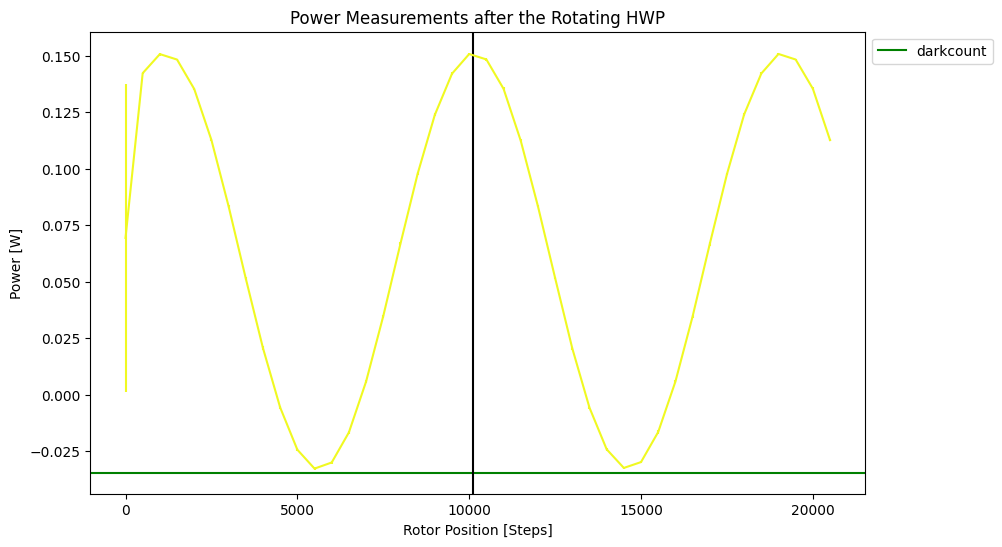

In [ ]:
fig, ax = plt.subplots(1,1, figsize =  (10,6))
ax.set_title('Power Measurements after the Rotating HWP')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Rotor Position [Steps]')

#darkcount line
ax.axhline(np.average(darkcounts['averaged']), color = 'green', label = 'darkcount')


rf = 12
data = all_after[rf]



rfname = os.path.basename(files_after_hwp[i+1]).split('rf')[1]

if (not '100' in rfname):
    rfname = rfname[0:2]
    label = f'rf{rfname}'
else:
    rfname = rfname[0:3]
    label = f'rf{rfname}'

print(i, label)
print('hello ! | ')
y = data['averaged']
error = np.array(data['stdev'])

# params, params_covariance = curve_fit(sine_function, x[3:], y[3:], p0 = [0.0361029908,0.0998, 3.87, 0.0046])
# plt.plot(x, sine_function(x, *params), label='Fitted Sine Function', color='red')
# print(i, "Fitted Parameters: A = {}, B = {}, C = {}, D = {}".format(*params))
try:
    ax.axhline(before_hwp_avg[label], color = colors2[i], label = f'{label} before hwp')
except KeyError:
    print(f'{label} isnt measured at before hwp')
# ax.scatter(x, y, label=label, marker='x')
# ax.plot(x, y, label=label, color = colors[i])
ax.errorbar(x = x, y = y, yerr=error, fmt='-o', color = colors2[i], markersize = 0)
# ax.errorbar(x = x, y = y, yerr=error, fmt='x', color = 'black', markersize = 1)
ax.axvline(10000+100, color = 'black')
    
ax.legend(ncol = 2 ,bbox_to_anchor = (1,1))